In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import matplotlib.colors as mcolors
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import HDBSCAN

# 设置路径
now_path = os.getcwd()
data_path=now_path+'\\..\\raw data\\'

# 读取数据函数
def extract_gene_name_from_index(index_str):
    """从索引字符串中提取基因名"""
    parts = index_str.split('_')
    if len(parts) >= 2:
        return parts[1]
    else:
        return index_str

# 读取数据
file1 = 'K562_essential_normalized_bulk_01.h5ad'
file2 = 'K562_gwps_normalized_bulk_01.h5ad'
file3 = 'rpe1_normalized_bulk_01.h5ad'

#K_e_n_b_adata=sc.read_h5ad(data_path+file1)
K_g_n_b_adata=sc.read_h5ad(data_path+file2)
#R_e_n_b_adata=sc.read_h5ad(data_path+file3)

# 添加target列
#K_e_n_b_adata.obs['target'] = [extract_gene_name_from_index(idx) for idx in K_e_n_b_adata.obs.index]
K_g_n_b_adata.obs['target'] = [extract_gene_name_from_index(idx) for idx in K_g_n_b_adata.obs.index]
#R_e_n_b_adata.obs['target'] = [extract_gene_name_from_index(idx) for idx in R_e_n_b_adata.obs.index]

#print(f"K562 essential: {K_e_n_b_adata.shape}")
print(f"K562 genome-wide: {K_g_n_b_adata.shape}")
#print(f"RPE1: {R_e_n_b_adata.shape}")


K562 genome-wide: (11258, 8248)


In [2]:
import torch
# 1. 全程 float32 + 不保留副本
torch.set_default_dtype(torch.float32)      # 让 pymde 也用 float32

# 2. 关掉 Jupyter 的自动大对象回传
os.environ["PYMDE_SUPPRESS_PLOTS"] = "1"
%config InlineBackend.figure_format = 'svg'

# 3. 单线程，防止 MKL/OPENBLAS 预分配
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [ ]:
#筛选强扰动（按照论文标准）
mask = (K_g_n_b_adata.obs['anderson_darling_counts'] >= 50) & \
       (K_g_n_b_adata.obs['target'] != 'non-targeting') & \
       (K_g_n_b_adata.obs['num_cells_unfiltered'] >= 25) & \
       (K_g_n_b_adata.obs['pct_expr'] <= -0.3)

strong = K_g_n_b_adata[mask].copy()
print(f"强扰动数量: {strong.shape[0]}")

强扰动数量: 1948


In [ ]:
ISR_genes = [   #ISR基因列表
    'SARS','ZCCHC8','GCAT','XBP1','TRIB3','MDK','RTN4','IGFBP2','CCND2',
    'ATF4','SESN2','MAP1B','SLC31A1','IDH1','WARS','HAX1','DDIT4','RNF41',
    'PRSS57','COLGALT2','CCPG1','LINC00662'
]

UPR_genes = [
    'HSPA5','HERPUD1','TRAM1','NUCB2','MYDGF','DNAJB11','DNAJC3','KDELR1',
    'SEC61B','SSR3','RPN2','SERP1','SSR1','CANX','SDF2L1','TMED7','KDELR2',
    'PDIA6','MANF','HYOU1','PDIA4','SSR2','HSP90B1','PPIB','PDIA3','CALR',
    'P4HB','SND1','DDOST'
]

Erythroid_genes = [
    'CHI3L2','OAT','BLVRB','KLF1','SLC2A1','NENF','NFE2','UROD','ASH2L',
    'APOC1','HBZ','TMOD1','HEMGN','SLC39A8','SORD','MFGE8','SLC25A37',
    'FEZ1','ERMAP','GFI1B','STAT3','FAM178B','TANGO2','C2orf88','HBG2',
    'ANXA6','MYL4','MPIG6B','HBA1','HBG1','UCA1','HBD','PVT1','HMBS',
    'AC079466.1','AC079801.1','AP001531.1'
]

Myeloid_genes = [
    'WAS','PIK3CB','CYBA','SPI1','BAX','LGALS1','PYCARD','TNNT1','PLIN3',
    'CD33','AIP','ARPC3','GNAI2','VAMP8','ELF1','VASP','RAC2','ARHGEF6',
    'ARPC1B','GMFG','CAP1','DOCK2','PAPSS1','SLC27A2','EMP3','SH3BGRL3',
    'EVA1B','CD53','PTPN7','PPP1R18','ABRACL','MSN','TAGLN2','LAPTM5',
    'ARPC5','S100A11','TPM4','GPRC5C','CAVIN1','FMNL1','IFITM2','SOCS1',
    'SMYD3','STAC3','SPN','CFD','TAFA2','AIF1','CLIC1'
]

In [67]:
strong

AnnData object with n_obs × n_vars = 1948 × 8248
    obs: 'UMI_count_unfiltered', 'num_cells_unfiltered', 'num_cells_filtered', 'control_expr', 'fold_expr', 'pct_expr', 'core_control', 'mean_leverage_score', 'std_leverage_score', 'energy_test_p_value', 'anderson_darling_counts', 'mann_whitney_counts', 'z_gemgroup_UMI', 'mitopercent', 'TE_ratio', 'cnv_score_z', 'target'
    var: 'gene_name', 'mean', 'std', 'cv', 'in_matrix', 'gini', 'clean_mean', 'clean_std', 'clean_cv'

In [ ]:
gene_names = strong.var['gene_name'].values
target_names = strong.obs['target'].values

# 创建DataFrame
df = pd.DataFrame(strong.X.toarray() if hasattr(strong.X, 'toarray') else strong.X.copy(), index=target_names, columns=gene_names) #行为扰动，列为基因
print(f"基因表达矩阵形状: {df.shape}")

高变基因表达矩阵形状: (1948, 8248)


In [ ]:
# 找出行列同名位置
# 取普通数组，避开 Categorical 比较限制
idx = np.asarray(df.index)          # 行名
col = np.asarray(df.columns)        # 列名

same_mask = idx[:, None] == col[None, :]   # 现在可以广播了
# 原地赋 0
df.values[same_mask] = 0

In [70]:
#df每一列z归一化
from scipy.stats import zscore
df_z = zscore(df, axis=0, ddof=1)

In [ ]:
df

In [ ]:
df_ISR=df_z.loc[:, df_z.columns.isin(ISR_genes)] #取出ISR基因对应的列
df_UPR=df_z.loc[:, df_z.columns.isin(UPR_genes)]
df_Ery=df_z.loc[:, df_z.columns.isin(Erythroid_genes)]
df_Mye=df_z.loc[:, df_z.columns.isin(Myeloid_genes)]

In [ ]:
ISR_scores=np.mean(df_ISR,axis=1)#取每一行的均值，作为ISR评分
UPR_scores=np.mean(df_UPR,axis=1)
Ery_scores=np.mean(df_Ery,axis=1)
Mye_scores=np.mean(df_Mye,axis=1)

In [ ]:
ISR_z_scores=stats.zscore(ISR_scores)#取ISR评分的z分数
UPR_z_scores=stats.zscore(UPR_scores)
Ery_z_scores=stats.zscore(Ery_scores)
Mye_z_scores=stats.zscore(Mye_scores)

In [84]:
# 按行索引合并ISR_z_scores和UPR_z_scores和Ery_z_scores和Mye_z_scores
combined_scores = pd.DataFrame({
    'ISR_z_scores': ISR_z_scores,
    'UPR_z_scores': UPR_z_scores,
    'Ery_z_scores': Ery_z_scores,
    'Mye_z_scores': Mye_z_scores
})

In [ ]:
from adjustText import adjust_text # 用于调整文本标签位置

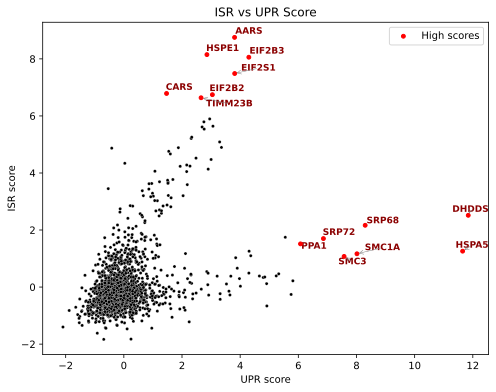

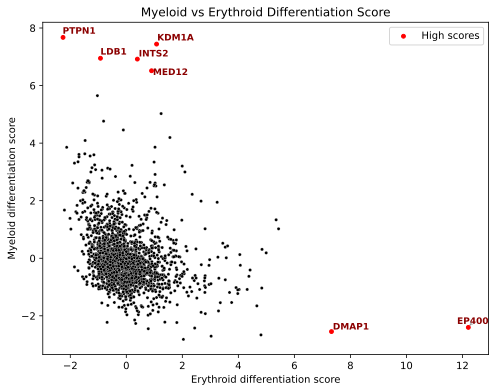

In [85]:
# 绘制图 C
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(data=combined_scores, x='UPR_z_scores', y='ISR_z_scores', s=10, color='black')

# 找出分数比较高的一些点
high_scores = combined_scores[(combined_scores['UPR_z_scores'] > 6) | (combined_scores['ISR_z_scores'] > 6)]

# 为这些点设置不同的颜色并标注
if not high_scores.empty:  # 确保有高亮点的存在
    texts = []  # 用于存储文本对象
    # 绘制高亮点
    plt.scatter(high_scores['UPR_z_scores'], high_scores['ISR_z_scores'], 
                color='red', s=15, label='High scores', zorder=5)
    
    # 为每个高亮点创建文本对象（先不绘制位置）
    for idx, row in high_scores.iterrows():
        text = plt.text(row['UPR_z_scores'], row['ISR_z_scores'], str(idx),
                       fontsize=9, color='darkred', fontweight='bold')
        texts.append(text)

# 调整文本位置避免重叠
if texts:
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
                expand_points=(1.2, 1.5),  # 让文本离点远一点
                expand_text=(1.1, 1.3),    # 让文本之间分开一点
                force_text=(0.5, 0.8),     # 调整文本之间的排斥力
                only_move={'points':'y', 'text':'xy'})  # 允许文本在xy方向移动

plt.title('ISR vs UPR Score')
plt.xlabel('UPR score')
plt.ylabel('ISR score')
plt.legend()
plt.show()

# 绘制图 D
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(data=combined_scores, x='Ery_z_scores', y='Mye_z_scores', s=10, color='black')

# 找出分数比较高的一些点
high_scores = combined_scores[(combined_scores['Ery_z_scores'] > 6) | (combined_scores['Mye_z_scores'] > 6)]

# 为这些点设置不同的颜色并标注
if not high_scores.empty:  # 确保有高亮点的存在
    texts = []  # 用于存储文本对象
    # 绘制高亮点
    plt.scatter(high_scores['Ery_z_scores'], high_scores['Mye_z_scores'], 
                color='red', s=15, label='High scores', zorder=5)
    
    # 为每个高亮点创建文本对象（先不绘制位置）
    for idx, row in high_scores.iterrows():
        text = plt.text(row['Ery_z_scores'], row['Mye_z_scores'], str(idx),
                       fontsize=9, color='darkred', fontweight='bold')
        texts.append(text)

# 调整文本位置避免重叠
if texts:
    adjust_text(texts, 
                arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
                expand_points=(1.2, 1.5),  # 让文本离点远一点
                expand_text=(1.1, 1.3),    # 让文本之间分开一点
                force_text=(0.5, 0.8),     # 调整文本之间的排斥力
                only_move={'points':'y', 'text':'xy'})  # 允许文本在xy方向移动

plt.title('Myeloid vs Erythroid Differentiation Score')
plt.xlabel('Erythroid differentiation score')
plt.ylabel('Myeloid differentiation score')
plt.legend()
plt.show()